In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import cv2 as cv

In [2]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square
from skimage import filters

In [3]:
import plotly.express as px
from helper import *

%load_ext autoreload
%autoreload 2

Import and plot setup data

In [4]:
path_data = 'data/image_setup/'

backs = path_data + 'back_cards.jpg'
cards = path_data + 'spades_suits.jpg'
kings = path_data + 'kings.jpg'
chips = path_data + 'chips.jpg'
paths = [backs, cards, kings, chips]

backs, cards, kings, chips = load_data(paths)
images = [backs, cards, kings, chips]

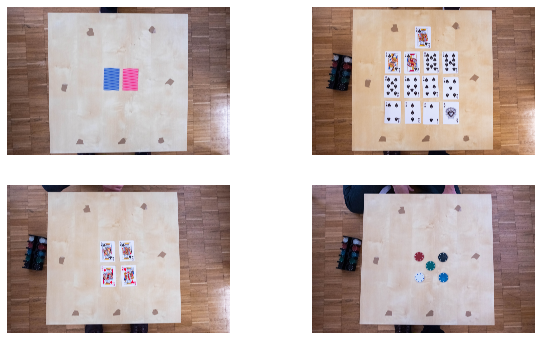

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))

for ax, image in zip(axes.flatten(), images):
    ax.imshow(image)
    ax.axis('off')
    ascii

## Cards treatment

In [6]:
print(cards.shape)

(4000, 6000, 3)


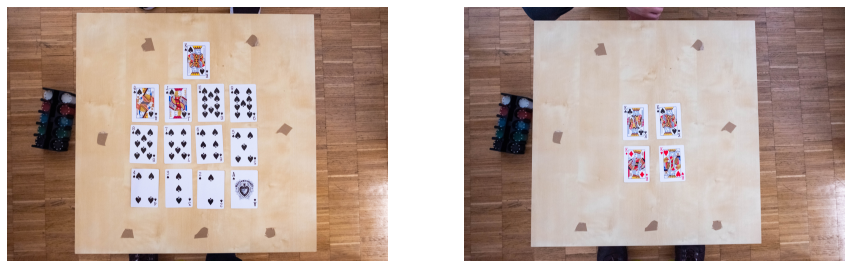

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
for image,ax in zip([cards, kings], axes):
    ax.imshow(image)
    ax.axis('off')
plt.show()

### Isolate cards, numbers and symbols (ground truth)

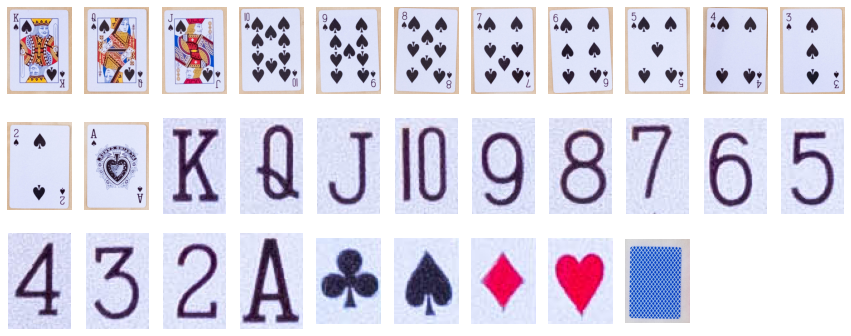

In [8]:
individual_cards, numbers, symbols = isolate_card_features(cards, kings)
all_images = individual_cards + numbers + symbols
back = backs[1600:2300,2560:3100]
all_images = all_images + [back]
#all_images = [skimage.filters.unsharp_mask(all_images[i], radius = 25, channel_axis = 2) for i in range(len(all_images))]
fig, axes = plt.subplots(ncols = 11, nrows = 3, figsize=(15,6))

for ax, image in zip(axes.flatten(),all_images):
    ax.imshow(image)
    ax.axis('off')
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')
plt.show()

## Looking for feature detectable on train images
### Edge detector + cleaning

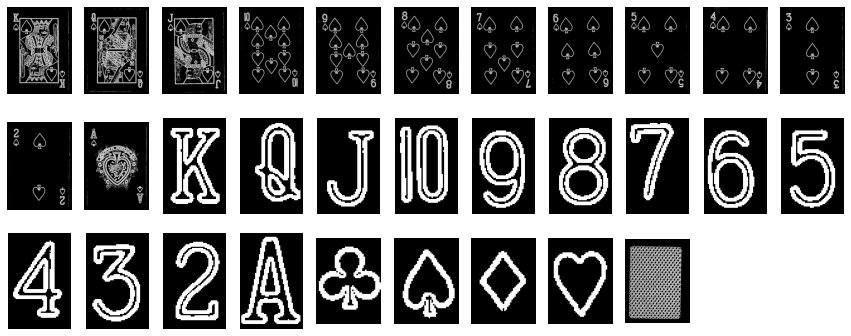

In [9]:
sobel_images = edge_detector(all_images)

fig, axes = plt.subplots(ncols = 11, nrows = 3, figsize=(15,6))
for ax, image in zip(axes.flatten(), sobel_images):
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis('off')
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')
plt.show()

### Contour detection on edge detector output
#### biggest contour per image

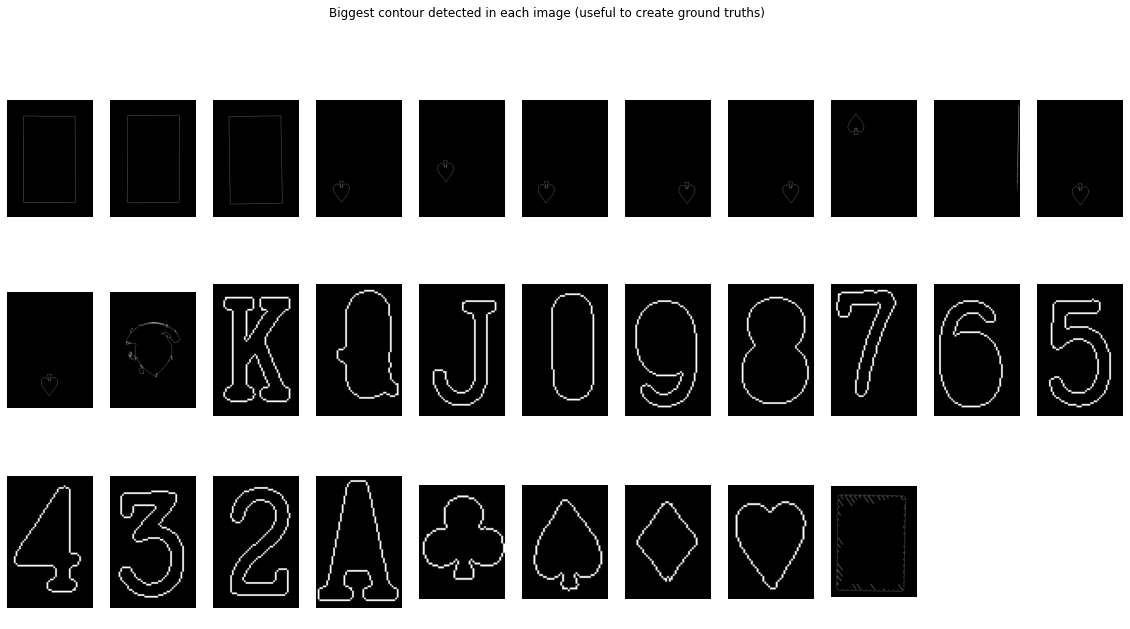

In [11]:
sobel_contours = one_contour_by_img(sobel_images)

fig, axes = plt.subplots(ncols = 11, nrows = 3, figsize=(20,10))
for ax, contour, image in zip(axes.flatten(), sobel_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.axis('off')
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')
fig.suptitle('Biggest contour detected in each image (useful to create ground truths)')
plt.show()

6 and 9 stuff

In [13]:
six_nine_ct = [sobel_contours[17], sobel_contours[20]]
six_nine_im = [all_images[17], all_images[20]]

In [18]:
six_nine_rot_ct = [rotate_contour(x).astype(int) for x in six_nine_ct]

In [ ]:
def six_or_nine_check(cards_ID, nb_contours, locations):
    """ Choose 6 or 9 by looking at distance between (rot) number and mean sym/nb location """
    output_ID = []
    for ID, ct, loc in zip(cards_ID, nb_contours, locations):
        final_ID = ID
        if ID[0] == '6' or ID[0] == '9':
            rot_ct = rotate_contour(ct)
            # compute center of contour and rot contour
            Cx = (np.max(ct[:,0]) + np.min(ct[:,0])) // 2
            Cy = (np.max(ct[:,1]) + np.min(ct[:,1])) // 2
            rot_Cx = (np.max(rot_ct[:,0]) + np.min(rot_ct[:,0])) // 2
            rot_Cy = (np.max(rot_ct[:,1]) + np.min(rot_ct[:,1])) // 2
            
            # compute distance
            print([Cx, Cy], loc)
            print([rot_Cx, rot_Cy], loc)
            dist = np.linalg.norm([Cx, Cy] - loc)
            rot_dist = np.linalg.norm([rot_Cx, rot_Cy] - loc)
            if dist > rot_dist: final_ID = '9' + ID[1]
            else: final_ID = '6' + ID[1]

        output_ID.append(final_ID)
    return output_ID

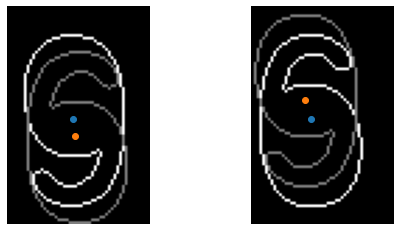

In [45]:
fig, axes = plt.subplots(ncols = 2, figsize=(8,4))
for ax, contour, image in zip(axes.flatten(), six_nine_ct, six_nine_im):
    im = np.zeros((image.shape[0]+1, image.shape[1]+1))
    CM = np.mean(contour, axis = 0)
    center = [(np.max(contour[:,0]) + np.min(contour[:,0]))//2, (np.max(contour[:,1]) + np.min(contour[:,1]))//2]
    im[contour[:,1], contour[:,0]] = 255
    
    ct_rot = rotate_contour(contour).astype(int)
    CM_rot = np.mean(ct_rot, axis = 0)
    center_rot = [(np.max(ct_rot[:,0]) + np.min(ct_rot[:,0]))//2, (np.max(ct_rot[:,1]) + np.min(ct_rot[:,1]))//2]
    im[ct_rot[:,1], ct_rot[:,0]] = 127
    
    ax.imshow(im, cmap='gray')
    #ax.scatter(CM[0], CM[1])
    #ax.scatter(CM_rot[0], CM_rot[1])
    ax.scatter(center[0], center[1])
    ax.scatter(center_rot[0], center_rot[1])
    #ax.scatter(center[0], center[1])
    ax.axis('off')
    
# fig, axes = plt.subplots(ncols = 2, figsize=(8,4))
# for ax, contour, image in zip(axes.flatten(), six_nine_rot_ct, six_nine_im):
#     im = np.zeros((image.shape[0]+1, image.shape[1]+1))
#     CM = np.mean(contour, axis = 0)
#     center = [(np.max(contour[:,0]) + np.min(contour[:,0]))//2, (np.max(contour[:,1]) + np.min(contour[:,1]))//2]
#     im[contour[:,1], contour[:,0]] = 255
#     ax.imshow(im, cmap='Reds')
#     ax.scatter(CM[0], CM[1])
#     ax.scatter(center[0], center[1])
#     ax.axis('off')

Note: when extracting full cards contours the biggest contour of "dressed" cards is the inner rectangle (and nothing inside is kept)

#### All contours in images

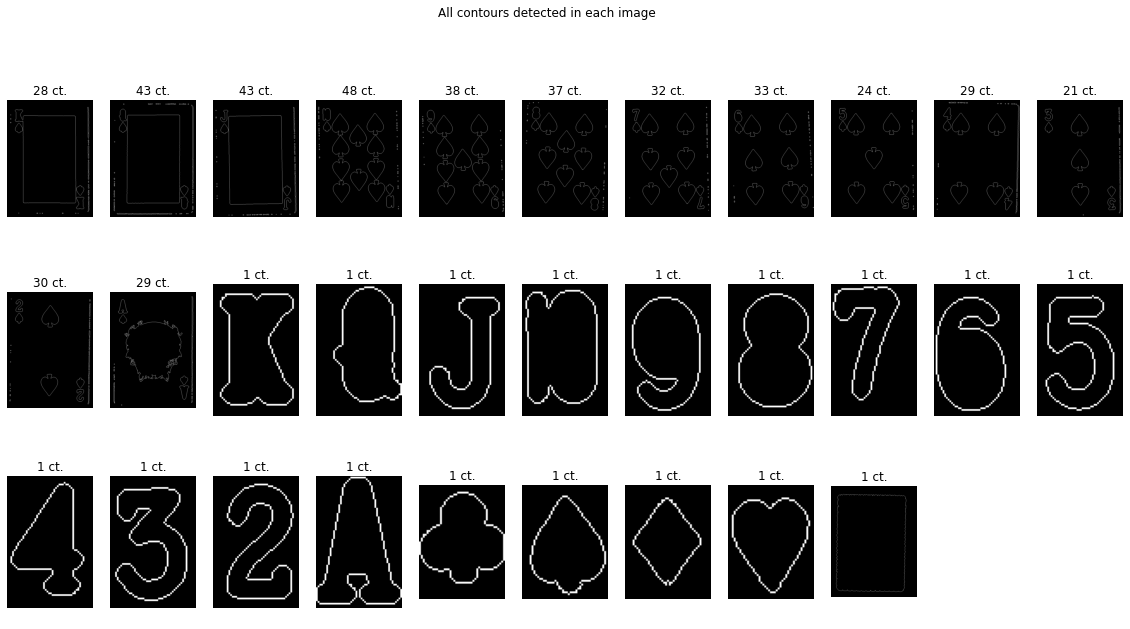

In [17]:
sobel_all_contours = contours_by_img(output)

fig, axes = plt.subplots(ncols = 11, nrows = 3, figsize=(20,10))
for ax, contours, image in zip(axes.flatten(), sobel_all_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')
fig.suptitle('All contours detected in each image')
plt.show()

We only find ourselves with the biggest and smallest contours (easy to clean out in theory) and symbols of interest.

#### Strategie from there: evaluate a range a contour length (tolerance because images not taken from same place each time) that we keep before making features (is it really necessary ?)

14


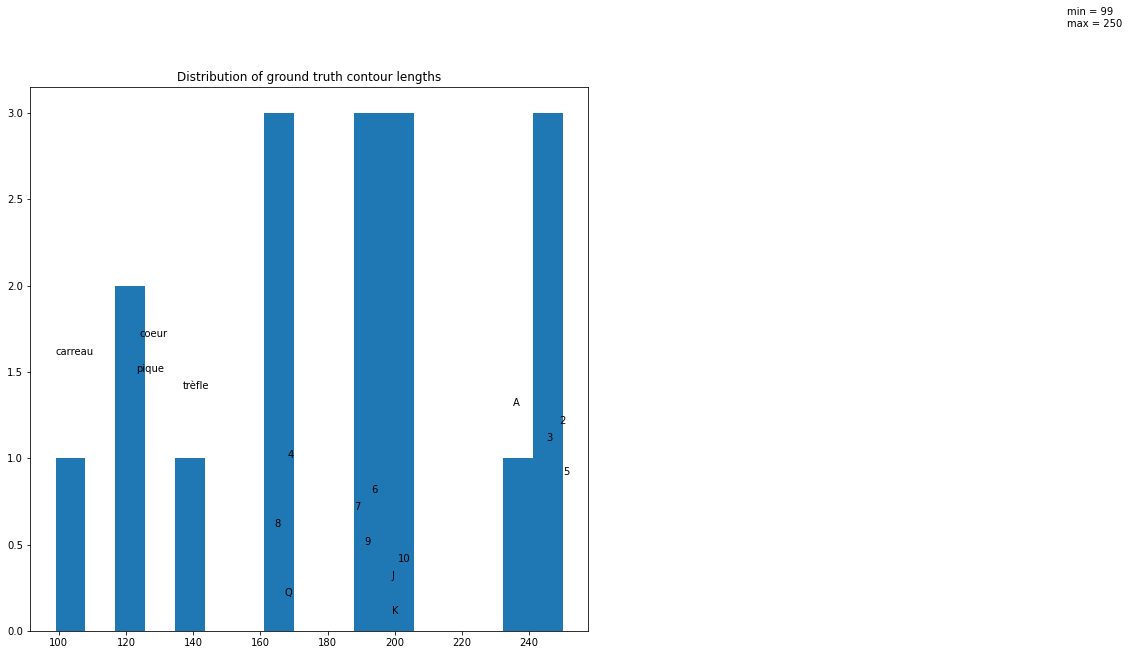

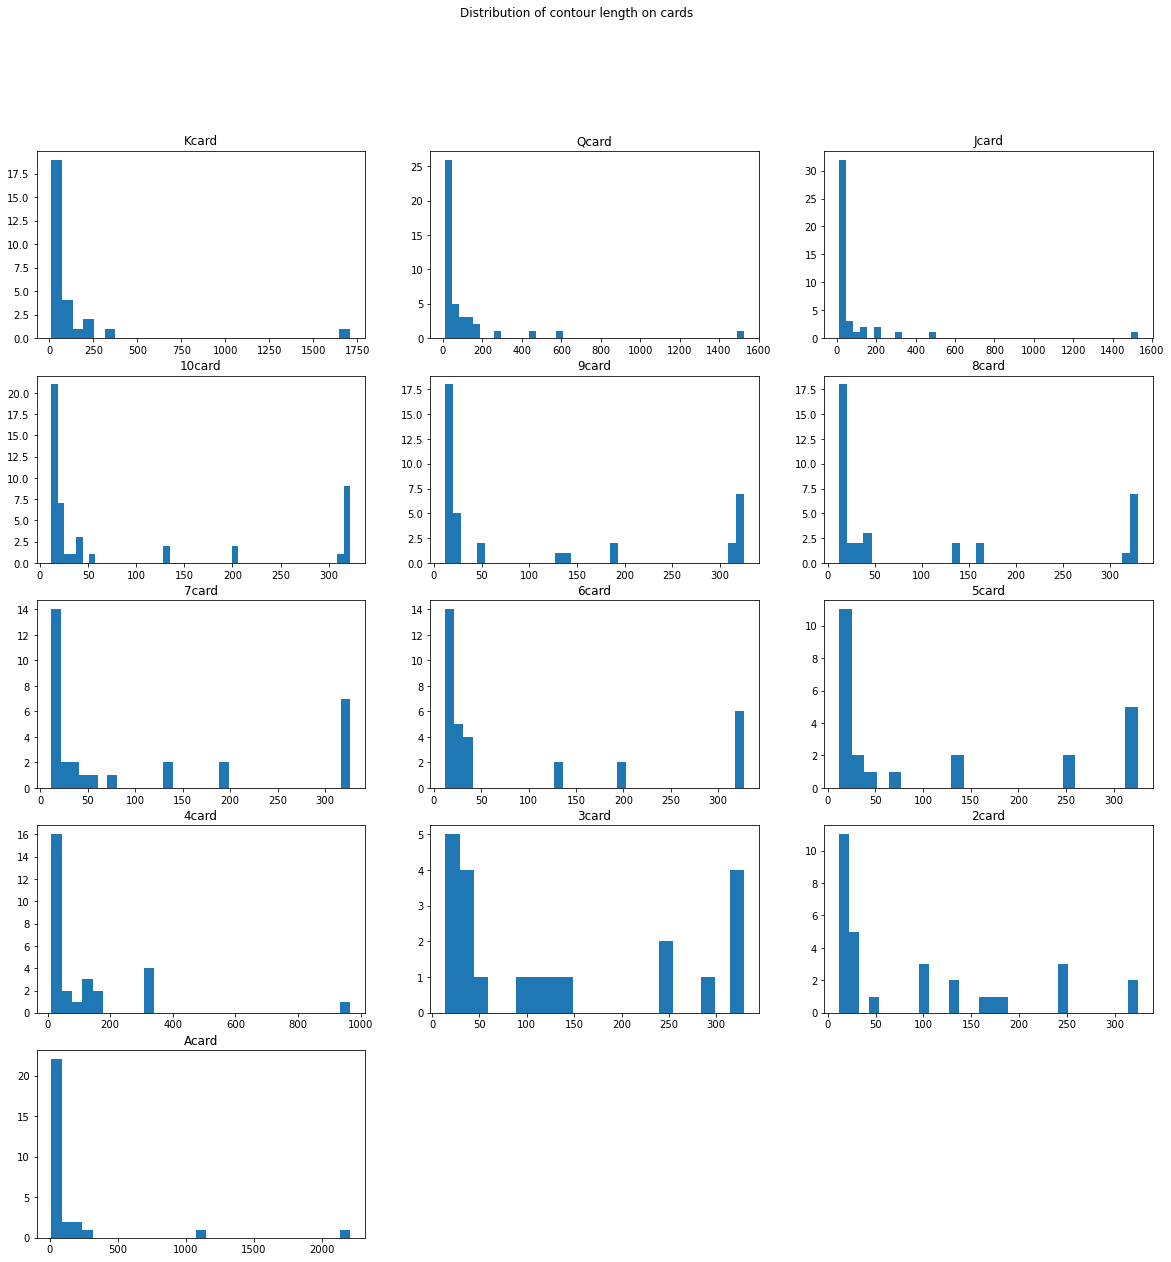

In [18]:
ground_truth_contours_len = [len(sobel_contours[i]) for i in range(13,30,1)]
cards_contours_len = sobel_all_contours[:13] + [sobel_all_contours[-1]]
print(len(cards_contours_len))

plot_coutours_length_distrib(cards_contours_len, ground_truth_contours_len)

We notice a lot of very small contours, most likely the cards rectangle contours which are cut into very small pieces. Let's try to get rid of that.

In [19]:
min_size, max_size = np.min(ground_truth_contours_len), np.max(ground_truth_contours_len)
tol_down, tol_up = 20, 20

cont_range = [min_size-tol_down, max_size+tol_up]

lower_bound = cont_range[0]
upper_bound = cont_range[1]
print(cont_range)

[79, 270]


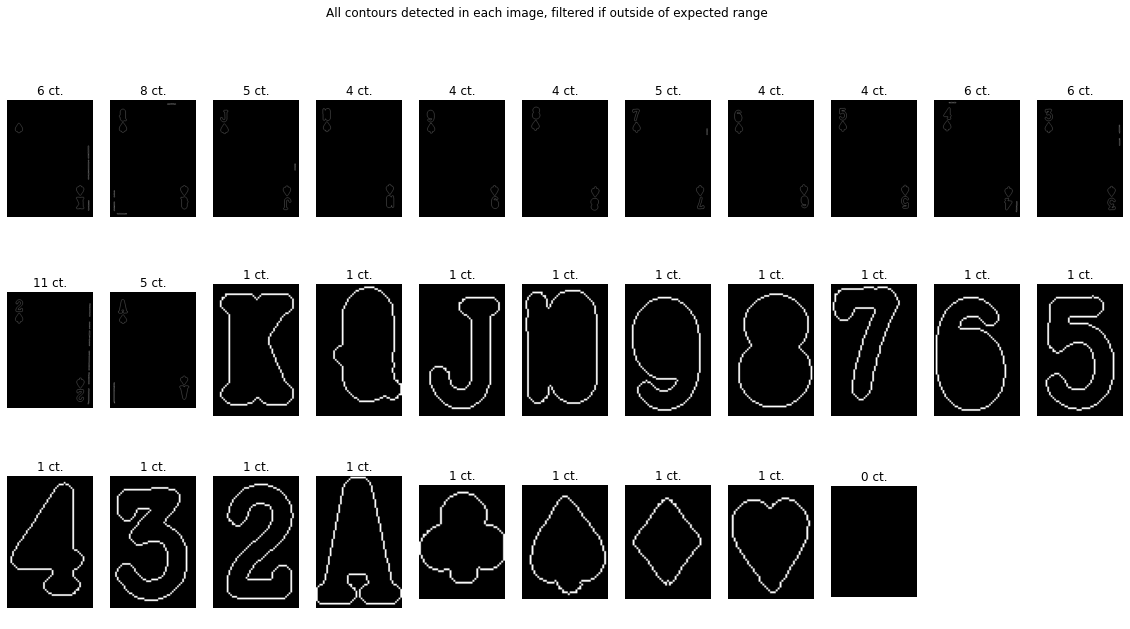

In [20]:
all_filtered_contours = filter_contours_by_size(sobel_all_contours, lower_bound, upper_bound)

fig, axes = plt.subplots(ncols = 11, nrows = 3, figsize=(20,10))
for ax, contours, image in zip(axes.flatten(), all_filtered_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')
fig.suptitle('All contours detected in each image, filtered if outside of expected range')
plt.show()

Note: the tolerance on size range really changes the random stuff found in the fourier field.

Except from a few artefacts of the rectangle card contours or ace shapes, there only remains shapes of interest, which we can transform into features to create ground truth features. Then, use them to recognise cards.

## Features creation

Use **ground_truth_contours** to create features and see how **cards_contours** align to those features and classified

Lets filter cards contours to avoid problems with fourier descriptor computation.

In [21]:
cards_contours = all_filtered_contours[:13]
ground_truth_contours = [sobel_contours[i] for i in range(13,30,1)]

Not use 1st descriptor f0 (affected by translation)

Use ratio of f1,f2,f3,f4 (otherwise not invariant to scaling) necessary? Because worst predictors than without that

Compute Fourier descriptors

In [22]:
n = 10
# compute ground truth descriptors
GT_descr = n_FT_descr(complex_contours(ground_truth_contours), n)

# compute all filtered cards contours descriptors
cards_comp_ct = [complex_contours(card_cont) for card_cont in cards_contours]
cards_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

Manipulate descriptors for invariance.

cards_3D_descr is a list of K x n array descriptors (K contours, n descr per contour)
GT_3D_descr is a 17 x 3 array descriptors (17 ground truths possible)

## try to acount for scaling by taking ratios

In [17]:
# cards_3D_descr = []
# for card_descr in cards_descr:
#     descr_1 = card_descr[:,1]/card_descr[:,3]
#     descr_2 = card_descr[:,2]/card_descr[:,4]
#     descr_3 = card_descr[:,5]/card_descr[:,7]
#     descr_4 = card_descr[:,6]/card_descr[:,8]
#     descr_5 = card_descr[:,9]/card_descr[:,10]
#     card_contours_descr = np.vstack([descr_1,descr_2,descr_3,descr_4,descr_5]).T
#     cards_3D_descr.append(card_contours_descr)
    
# descr_1 = GT_descr[:,1]/GT_descr[:,3]
# descr_2 = GT_descr[:,2]/GT_descr[:,4]
# descr_3 = GT_descr[:,5]/GT_descr[:,7]
# descr_4 = GT_descr[:,6]/GT_descr[:,8]
# descr_5 = GT_descr[:,9]/GT_descr[:,10]

# GT_3D_descr = np.vstack([descr_1,descr_2,descr_3,descr_4,descr_5]).T

# print(len(cards_3D_descr), cards_3D_descr[0].shape)
# print(GT_3D_descr.shape)

## Not accounting for scaling

In [23]:
cards_3D_descr = []
for card_descr in cards_descr:
    descr_1 = card_descr[:,1]
    descr_2 = card_descr[:,2]
    descr_3 = card_descr[:,3]
    descr_4 = card_descr[:,4]
    descr_5 = card_descr[:,5]
    descr_6 = card_descr[:,6]
    descr_7 = card_descr[:,7]
    descr_8 = card_descr[:,8]
    descr_9 = card_descr[:,9]
    card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                     descr_4,descr_5,descr_6,
                                    descr_7,descr_8,descr_9]).T
    cards_3D_descr.append(card_contours_descr)
    
    descr_1 = GT_descr[:,1]
    descr_2 = GT_descr[:,2]
    descr_3 = GT_descr[:,3]
    descr_4 = GT_descr[:,4]
    descr_5 = GT_descr[:,5]
    descr_6 = GT_descr[:,6]
    descr_7 = GT_descr[:,7]
    descr_8 = GT_descr[:,8]
    descr_9 = GT_descr[:,9]

GT_3D_descr = np.vstack([descr_1,descr_2,descr_3,
                         descr_4,descr_5,descr_6,
                        descr_7,descr_8,descr_9]).T

print(len(cards_3D_descr), cards_3D_descr[0].shape)
print(GT_3D_descr.shape)
np.save('GT_descr', GT_3D_descr, allow_pickle = True)

13 (6, 9)
(17, 9)


In [19]:
#plot_fourier_descr_and_card_contours(GT_3D_descr, cards_3D_descr, card_idx = 4)

In [20]:
#plot_fourier_descr_3D(GT_3D_descr)

In [24]:
#GT_df = pd.DataFrame(GT_3D_descr, columns = ['descr 1', 'descr 2', 'descr 3'], index = ground_truth_titles)
GT_df = pd.DataFrame(GT_3D_descr, columns = ['descr 1', 'descr 2', 'descr 3', 'descr 4', 'descr 5', 'descr 6', 'descr 7', 'descr 8', 'descr 9'], index = ground_truth_titles)
print(GT_df)

             descr 1      descr 2      descr 3     descr 4     descr 5  \
K        1468.970213   178.100376   798.716926  115.047188  103.409137   
Q        1054.389518   243.323726   127.137057   90.744904   86.459869   
J        2081.286815    764.17018   467.178658  214.257623  124.313234   
10         976.23935   187.621016   433.408336   13.751741  153.354583   
9         1210.14998   272.682103   273.137784  211.634459  140.331821   
8         784.241868   106.643274   133.229651   67.394706   97.272001   
7        1687.646857  1002.269275   168.299672  105.880835  169.258587   
6        1243.059896   293.679638   288.481018  219.270593  147.496773   
5        2271.755269   436.570812  1008.949094  367.910131  574.234496   
4         886.850782   635.669753   251.205742   78.400158   80.845955   
3        2248.134838   720.585613   662.063929  418.027992  571.750434   
2        2532.302169   125.976449  1319.095041  174.232118  524.750218   
A        1404.416304  1466.441353   18

9 AND 6 HAVE OBVIOUSLY SIMILAR FOURIER DESCRIPTOR => NEED TO FIND A NON-FOURIER DESCRIPTOR TO DIFFERENTIATE THEM

In [22]:
#plot_interactive_3D_descr(GT_df)

In [25]:
def predict_cards_from_predictors(cards_3D_descr, GT_3D_descr, number_keys, symbol_keys):
    pred_numbers = []
    pred_symbols = []
    for card_all_descr in cards_3D_descr:
        # check returned card case
        if (card_all_descr == np.zeros(9)).all():
            pred_numbers.append('0')
            pred_symbols.append('0')
            
        else:
            # for each number, compute minimal distance to it
            dist_to_numbers = []
            for i in range(GT_3D_descr.shape[0]-4):
                diff = card_all_descr - GT_3D_descr[i,:]
                dist = np.linalg.norm(diff.astype(float), axis = 1)
                dist_to_numbers.append(np.min(dist))
            idx = np.argmin(dist_to_numbers)
            pred_numbers.append(number_keys[idx])

            # for each symbol, compute minimal distance to it
            dist_to_symbols = []
            for i in range(GT_3D_descr.shape[0]-4, GT_3D_descr.shape[0], 1):
                diff = card_all_descr - GT_3D_descr[i,:]
                #dist = diff[:,0]**2 + diff[:,1]**2 + diff[:,2]**2
                dist = np.linalg.norm(diff.astype(float), axis = 1) # more general
                dist_to_symbols.append(np.min(dist))
            idx = np.argmin(dist_to_symbols)
            pred_symbols.append(symbol_keys[idx])
        
    return pred_numbers, pred_symbols

In [26]:
number_key = {0 : 'K', 1 : 'Q', 2 : 'J', 3 : '10', 4 : '9',
            5 : '8', 6 : '7', 7 : '6', 8 : '5', 9 : '4',
            10 : '3', 11 : '2', 12 : 'A'}
symbol_key = {0 : 'trèfle', 1 : 'pique', 2 : 'carreau', 3 : 'coeur'}

pred_numbers, pred_symbols = predict_cards_from_predictors(cards_3D_descr, GT_3D_descr, number_key, symbol_key)

In [27]:
print(f'Expected number/letter: {ground_truth_titles[:-4]}')
print(f'Predicted number/letter: {pred_numbers}')
print('\n')
print(f'Expected symbol: only pique')
print(f'Predicted symbol: {pred_symbols}')

Expected number/letter: ['K', 'Q', 'J', '10', '9', '8', '7', '6', '5', '4', '3', '2', 'A']
Predicted number/letter: ['K', 'Q', 'J', '10', '9', '8', '7', '6', '5', '4', '3', '2', 'A']


Expected symbol: only pique
Predicted symbol: ['pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique', 'pique']


stable ? we dont account for scaling here

## Trial on random image

In [26]:
test_img = 'data/train/train_00.jpg'
test_img = load_data([test_img])[0]

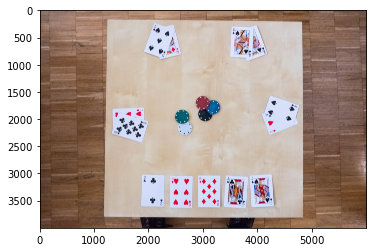

In [27]:
plt.imshow(test_img)
plt.show()

In [28]:
def plot_card(idx, idy, r, c):
    fig, axes = plt.subplots(ncols=5, figsize=(10,6))
    for ax,x,y in zip(axes.flatten(),idx, idy):
        ax.imshow(test_img[x:x+r,y:y+c])
        ax.axis('off')
    plt.show()

In [29]:
idx = [3000,3020,3000,3020,3000]
row = 640
idy = [1840,2360,2860,3360,3840]
col = 470

test_cards = []
for x,y in zip(idx, idy):
    card = test_img[x:x+row, y:y+col]
    test_cards.append(card)
test_cards.append(back)

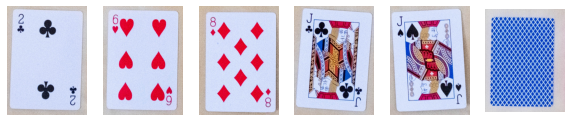

In [30]:
#plot_card(idx,idy,row,col)

fig, axes = plt.subplots(ncols = 6, figsize=(10,6))

for ax, image in zip(axes.flatten(),test_cards):
    ax.imshow(image)
    ax.axis('off')
plt.show()

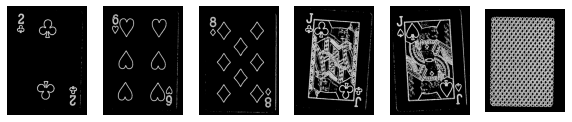

In [31]:
sobel_test_images = edge_detector(test_cards)

fig, axes = plt.subplots(ncols = 6, nrows = 1, figsize=(10,6))
for ax, image in zip(axes.flatten(), sobel_test_images):
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis('off')
plt.show()

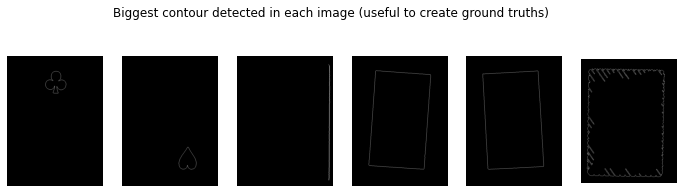

In [32]:
test_contours = one_contour_by_img(sobel_test_images)

fig, axes = plt.subplots(ncols = 6, figsize=(12,8))
for ax, contour, image in zip(axes.flatten(), test_contours, test_cards):
    im = np.zeros((image.shape[0], image.shape[1]))
    im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.axis('off')
fig.suptitle('Biggest contour detected in each image (useful to create ground truths)', y = 0.7)
plt.show()

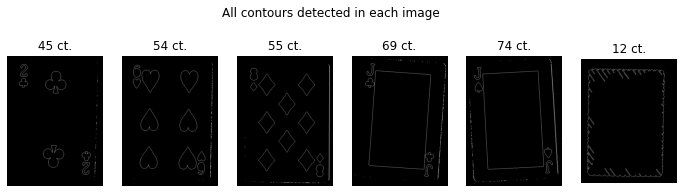

In [33]:
test_all_contours = contours_by_img(sobel_test_images)

fig, axes = plt.subplots(ncols = 6, figsize=(12,8))
for ax, contours, image in zip(axes.flatten(), test_all_contours, test_cards):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image', y = 0.7)
plt.show()

In [34]:
def filter_contours_by_size(sobel_all_contours, lower_bound, upper_bound):
    all_filtered_contours = []
    for contours in sobel_all_contours:
        image_conts = []
        for contour in contours:
            size = len(contour)
            if size > lower_bound and size < upper_bound:
                image_conts.append(contour)
        all_filtered_contours.append(image_conts)
    return all_filtered_contours

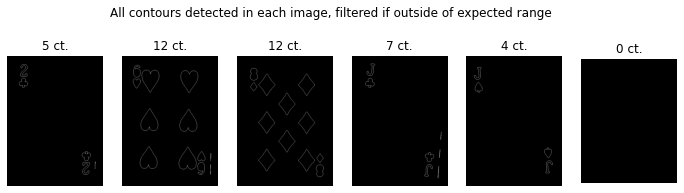

In [35]:
test_filtered_contours = filter_contours_by_size(test_all_contours, lower_bound, upper_bound)

fig, axes = plt.subplots(ncols = 6, figsize=(12,8))
for ax, contours, image in zip(axes.flatten(), test_filtered_contours, test_cards):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image, filtered if outside of expected range', y = 0.7)
plt.show()

In [36]:
n = 15
cards_comp_ct = [complex_contours(card_cont) for card_cont in test_filtered_contours]
test_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

In [40]:
test_3D_descr = []
for card_descr in test_descr:
    if len(card_descr)!=0:
        descr_1 = card_descr[:,1]
        descr_2 = card_descr[:,2]
        descr_3 = card_descr[:,3]
        descr_4 = card_descr[:,4]
        descr_5 = card_descr[:,5]
        descr_6 = card_descr[:,6]
        descr_7 = card_descr[:,7]
        descr_8 = card_descr[:,8]
        descr_9 = card_descr[:,9]
        card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                         descr_4,descr_5,descr_6,
                                        descr_7,descr_8,descr_9]).T
    else: card_contours_descr = np.zeros(9)
    test_3D_descr.append(card_contours_descr)

In [41]:
#plot_fourier_descr_and_card_contours(GT_3D_descr, test_3D_descr, card_idx = 1)

In [42]:
number_key = {0 : 'K', 1 : 'Q', 2 : 'J', 3 : '10', 4 : '9',
            5 : '8', 6 : '7', 7 : '6', 8 : '5', 9 : '4',
            10 : '3', 11 : '2', 12 : 'A'}
symbol_key = {0 : 'trèfle', 1 : 'pique', 2 : 'carreau', 3 : 'coeur'}

pred_numbers, pred_symbols = predict_cards_from_predictors(test_3D_descr, GT_3D_descr, number_key, symbol_key)

In [43]:
print(f'Expected number/letter: [2,   6,   8,   J,   J, 0]')
print(f'Predicted number/letter: {pred_numbers}')
print('\n')
print(f'Expected symbol: [trèfle,   coeur,   carreau,   trèfle,   pique, 0]')
print(f'Predicted symbol: {pred_symbols}')

Expected number/letter: [2,   6,   8,   J,   J]
Predicted number/letter: ['2', '9', '8', 'J', 'J', '0']


Expected symbol: [trèfle,   coeur,   carreau,   trèfle,   pique]
Predicted symbol: ['trèfle', 'coeur', 'carreau', 'trèfle', 'pique', '0']
